# Correspondence Autoencoder CNN for Acoustic Word Embeddings

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [197]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

import batching
import data_io
import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [199]:
# Training data

# NumPy archive (UTD)
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
    )

# # NumPy archive (ground truth)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff.dd.npz")
#     )

# # NumPy archive (larger ground truth)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff2.dd.npz")
#     )

# Data and labels
i_type = 0
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12045
E.g. item shape: (61, 39)


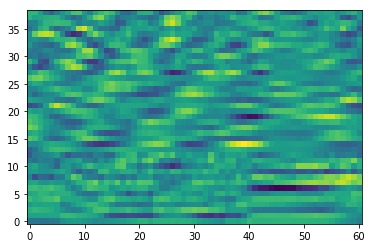

In [200]:
plt.imshow(train_x[3277].T, origin="bottom");

In [201]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2732
E.g. item shape: (61, 39)


In [202]:
# Truncate and limit dimensionality
max_length = 101
d_frame = 13
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

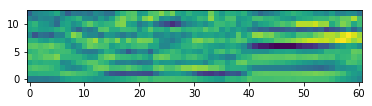

In [203]:
plt.imshow(train_x[3277].T, origin="bottom");

In [204]:
# Zero-pad and reshape
train_x, _, train_mask = data_io.pad_sequences(train_x, max_length, True, return_mask=True)
val_x, _, val_mask = data_io.pad_sequences(val_x, max_length, True, return_mask=True)
train_x = np.transpose(train_x, (0, 2, 1))
val_x = np.transpose(val_x, (0, 2, 1))

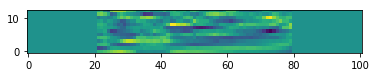

In [205]:
i_item = 3227
plt.imshow(train_x[i_item], origin="bottom");

In [206]:
print("Mask from", np.where(train_mask[i_item] == 1)[0][0], "to", np.where(train_mask[i_item] == 1)[0][-1] + 1)

Mask from 21 to 80


## AE-CNN

In [207]:
def get_conv2d_transpose_output_shape(input_shape, filter_shape, stride=1):
    """
    Calculate the output shape of a transposed convolution operation.
    
    See https://stackoverflow.com/questions/46885191.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    filter_height = filter_shape[0]
    filter_width = filter_shape[1]
    output_height = (input_height - 1)*stride + filter_height
    output_width = (input_width - 1)*stride + filter_width
    return [input_shape[0], output_height, output_width, filter_shape[2]]


def get_conv2d_transpose_filter_shape(input_shape, output_shape, stride=1):
    """
    Calculate the filter shape of a transposed convolution given a desired output shape.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    output_shape : list
        The shape of the output to the CNN as [n_data, height, width, d_out].

    Return
    ------
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    output_height = output_shape[1]
    output_width = output_shape[2]
    filter_height = output_height - (input_height - 1)*stride
    filter_width = output_width - (input_width - 1)*stride
    return [filter_height, filter_width, output_shape[3], input_shape[3]]


In [321]:
def build_ae_cnn(x, input_shape, filter_shapes, pool_shapes,
        build_latent_func, latent_func_kwargs, strides=None,
        decoder_filter_shapes=None, decoder_pool_shapes=None,
        decoder_strides=None, activation=tf.nn.relu):
    """
    Build an autoencoding CNN.

    See `tflego.build_cnn` for more details on the parameters. If the
    `decoder` shapes are not provided, these are inferred automatically from
    the encoder shapes given in `filter_shapes`, `pool_shapes` and `strides`. If the `decoder`
    parameters are provided, the first and last transposed convolutional
    shapes are still inferred from the other parameters.

    Parameters
    ----------
    x : Tensor [n_data, n_input]
        Input to the CNN, which is reshaped to match `input_shape`.
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    build_latent_func : function
        The function to build the latent layer inbetween the CNN encoder and decoder.
        The function's first parameter should be the input Tensor, and it should return
        a dictionary with an element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    """
    
    # Encoder
    network_input_shape = input_shape
    print("CNN input shape: {}".format(input_shape))
    encoder, layer_shapes = tflego.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="VALID", return_shapes=True, strides=strides)
    encoder = tf.contrib.layers.flatten(encoder)
    
    # Latent layer
    latent_layer = build_latent_func(encoder, **latent_func_kwargs)
    x = latent_layer["y"]
    d_latent_layer_output = x.get_shape().as_list()[-1]
    x = activation(x)
    
    # Replace None with -1 in `layer_shapes`
    for i, layer in enumerate(layer_shapes):
        layer_shapes[i] = [i if i is not None else -1 for i in layer]
    
    # Decoder dimensionalities
    if decoder_pool_shapes is None:
        decoder_pool_shapes = pool_shapes[::-1]
    if decoder_strides is None:
        decoder_strides = strides[::-1]
    if decoder_filter_shapes is None:
        decoder_layer_shapes = layer_shapes[::-1]
    else:
        decoder_layer_shapes = []
        decoder_layer_shapes.append(layer_shapes[-1])
        decoder_layer_shapes.append(layer_shapes[0])
        decoder_filter_shapes = decoder_filter_shapes.copy()
    #     for i, layer in enumerate(layer_shapes):
    #         decoder_layer_shapes[i] = [i if i is not None else -1 for i in layer]
#     else:
#         decoder_layer_shapes = []
#         decoder_layer_shapes.append([i if i is not None else -1 for i in layer_shapes[-1]])
#         print("0", decoder_layer_shapes[-1])
#         i_decoder_layer = 1
#         for decoder_filter_shape in decoder_filter_shapes:
#             if decoder_strides is not None:
#                 stride = decoder_strides[i_decoder_layer]
#             else:
#                 stride = 1
#             decoder_layer_shapes.append(
#                 get_conv2d_transpose_output_shape(decoder_layer_shapes[-1], decoder_filter_shape, stride)
#                 )
#             print("0", decoder_layer_shapes[-1])
#             i_decoder_layer += 1
    
    # Decoder
    i_layer = 0
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        x = tf.reshape(x, [-1, 1, 1, x.get_shape().as_list()[-1]])
        print("CNN transpose layer {} shape: {}".format(i_layer, x.get_shape().as_list()))
        decoder = tflego.build_unmaxpool2d(x, decoder_pool_shapes.pop(0))
    while len(decoder_pool_shapes) > 0:
        i_layer += 1
        with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):

            # Transposed convolution
            if decoder_strides is not None:
                stride = decoder_strides.pop(0)
            else:
                stride = 1
            input_shape = decoder.get_shape().as_list()
            if decoder_filter_shapes is None:
                output_shape = decoder_layer_shapes.pop(0)
            else:
                output_shape = get_conv2d_transpose_output_shape(input_shape, decoder_filter_shapes.pop(0), stride)
            filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape, stride)
            print("1", filter_shape)
            decoder = tflego.build_conv2d_transpose(decoder, filter_shape, stride)
            print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

            # Unpool
            decoder = tflego.build_unmaxpool2d(decoder, decoder_pool_shapes.pop(0))

    # Last decoder linear layer
    i_layer += 1
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        input_shape = decoder.get_shape().as_list()
        output_shape = network_input_shape
        filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape)
        print("2", filter_shape)
        decoder = tflego.build_conv2d_transpose(decoder, filter_shape, activation=tf.identity)
        print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

    return {"latent_layer": latent_layer, "decoder_output": decoder}

In [327]:
tf.reset_default_graph()

# Data
d_in = train_x.shape[1]*train_x.shape[2]
train_x_array = train_x.reshape((-1, d_in))
val_x_array = val_x.reshape((-1, d_in))
pair_list = batching.get_pair_list(train_labels)

# Training parameters
learning_rate = 0.001
ae_n_epochs = 50
ae_n_val_interval = 25
ae_batch_size = 600

# Model parameters
input_shape = [-1, train_x.shape[1], train_x.shape[2], 1]  # [n_data, height, width, channels]
# filter_shapes = [
#     [13, 9, 1, 100],
#     [1, 8, 100, 100],
#     [1, 8, 100, 200],
#     ]
# pool_shapes = [
#     [1, 1],
#     [1, 1],
#     [1, 1],
#     ]
# strides = [
#     3,
#     3,
#     1
#     ]

filter_shapes = [
    [13, 8, 1, 200],
    [1, 8, 200, 400],
    [1, 20, 400, 1000],
    ]
pool_shapes = [
    [1, 2],
    [1, 2],
    [1, 1],
    ]
strides = [
    1,
    1,
    1
    ]
decoder_filter_shapes = [
    [1, 20, 100, 100],
    [1, 8, 100, 100],
    ]
decoder_pool_shapes = [
    [1, 1],
    [1, 2],
    [1, 2]
    ]
decoder_strides = [
    1,
    1,
    1
    ]


build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],   # tune
    "n_z": 130,
    "dec_n_hiddens": [200],  # needs to be the same as channels in last conv layer
    "activation": tf.nn.relu
    }
intermediate_model_fn = path.join(output_dir, "ae_cnn.tmp.ckpt")
model_fn = path.join(output_dir, "ae_cnn.ckpt")

# Model
a = tf.placeholder(TF_DTYPE, [None, d_in])
b = tf.placeholder(TF_DTYPE, [None, d_in])
a_mask = tf.placeholder(TF_DTYPE, [None, input_shape[2]])
b_mask = tf.placeholder(TF_DTYPE, [None, input_shape[2]])

network_dict = build_ae_cnn(
    a, input_shape, filter_shapes, pool_shapes, build_latent_func, latent_func_kwargs, strides=strides,
    decoder_filter_shapes=decoder_filter_shapes, decoder_pool_shapes=decoder_pool_shapes, decoder_strides=decoder_strides
    )
latent = network_dict["latent_layer"]
z = latent["z"]
y = network_dict["decoder_output"]

# Reshape output and target to be compatible with loss
y1 = y  # temp
y = tf.transpose(y, [0, 2, 1, 3])
# print(y.get_shape().as_list()) # temp
y = tf.squeeze(y)
y2 =y # temp
y *= tf.expand_dims(b_mask, -1)  # mask output
y3 = y # temp
y_target = tf.reshape(b, input_shape[:3])
y_target1 = y_target # temp
y_target = tf.transpose(y_target, [0, 2, 1])
y_target2 = y_target # temp

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(y_target - y), -1), -1) /
    tf.reduce_sum(b_mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

CNN input shape: [-1, 13, 101, 1]
CNN layer 0 shape: [None, 1, 47, 200]
CNN layer 1 shape: [None, 1, 20, 400]
CNN layer 2 shape: [None, 1, 1, 1000]
CNN transpose layer 0 shape: [None, 1, 1, 200]
1 [1, 20, 100, 200]
CNN transpose layer 1 shape: [None, 1, 20, 100]
1 [1, 8, 100, 100]
CNN transpose layer 2 shape: [None, 1, 47, 100]
2 [13, 8, 1, 100]
CNN transpose layer 3 shape: [None, 13, 101, 1]


In [328]:
class PairedMaskIterator(object):
    """Iterator over pairs of padded sequences with their masks."""
    
    def __init__(self, x_mat, mask_mat, pair_list, batch_size, shuffle_every_epoch=False):
        self.x_mat = x_mat
        self.mask_mat = mask_mat
        self.pair_list = pair_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_batches = int(np.floor(x_mat.shape[0]/batch_size))
        self.indices = np.arange(len(pair_list))
        self.shuffle()
    
    def shuffle(self):
        np.random.shuffle(self.indices)

    def __iter__(self):
        if self.shuffle_every_epoch:
            self.shuffle()
        for i_batch in range(self.n_batches):
            
            # Indices
            batch_pair_list = [
                self.pair_list[i] for i in self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size]
                ]
            batch_indices_a = [i for i, j in batch_pair_list]
            batch_indices_b = [j for i, j in batch_pair_list]

            # Batch data and mask
            batch_a = self.x_mat[batch_indices_a]
            batch_b = self.x_mat[batch_indices_b]
            batch_mask_a = self.mask_mat[batch_indices_a]
            batch_mask_b = self.mask_mat[batch_indices_b]
            
            yield (batch_a, batch_mask_a, batch_b, batch_mask_b)


In [329]:
def samediff_val(normalise=True):
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = batching.LabelledIterator(
        val_x_array, y_vec=None, batch_size=val_x.shape[0], shuffle_every_epoch=False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x in val_batch_iterator:
            np_z = session.run(
                [z], feed_dict={a: batch_x}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate(
            [val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

    # Same-different
    if normalise:
        np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
        distances = pdist(np_z_normalised, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )
    else:
        distances = pdist(np_z, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )    
    return [prb, -ap]


(600, 1313) (600, 101) (600, 1313) (600, 101)
1 (600, 13, 101, 1)
2 (600, 101, 13)
5 (600, 101, 13)
max: 0.7199764 min: -0.8561016
3 (600, 13, 101)
4 (600, 101, 13)


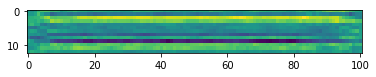

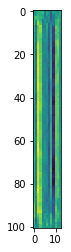

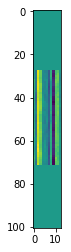

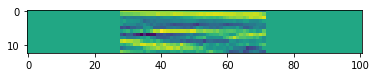

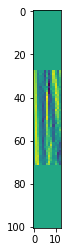

In [330]:
# Temp

train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
    )

for a_np, a_mask_np, b_np, b_mask_np in train_batch_iterator:
    print(a_np.shape, a_mask_np.shape, b_np.shape, b_mask_np.shape)

    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        
        # Output
        tf_output1 = y1.eval({a: a_np})
        tf_output2 = y2.eval({a: a_np})
        tf_output5 = y3.eval({a: a_np, b_mask: b_mask_np})
        tf_output3 = y_target1.eval({b: b_np})
        tf_output4 = y_target2.eval({b: b_np})
    break

print("1", tf_output1.shape)
plt.figure();
plt.imshow(tf_output1[0, :, :, 0]);

print("2", tf_output2.shape)
plt.figure();
plt.imshow(tf_output2[0, :, :]);

print("5", tf_output5.shape)
print("max:", np.max(tf_output5), "min:", np.min(tf_output5),)
plt.figure();
plt.imshow(tf_output5[0, :, :]);

print("3", tf_output3.shape)
plt.figure();
plt.imshow(tf_output3[0, :, :]);

print("4", tf_output4.shape)
plt.figure();
plt.imshow(tf_output4[0, :, :]);

# plt.imshow(tf_output2[])

In [331]:
# Train AE

np.random.seed(1)

train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn

record_dict = training.train_fixed_epochs_external_val(
    ae_n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_mask, b, b_mask], samediff_val,
    save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=ae_n_val_interval
    )

2019-06-10 08:04:04.974877
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae_cnn.tmp.ckpt
3.642 sec, train loss: 1.1196699, val loss: [0.021229764187888057, -0.005659723103672466] *
Epoch 1:
1.453 sec, train loss: 1.0348599
Epoch 2:
0.868 sec, train loss: 0.92839557
Epoch 3:
1.323 sec, train loss: 0.8570417
Epoch 4:
1.120 sec, train loss: 0.784062
Epoch 5:
1.103 sec, train loss: 0.72744226
Epoch 6:
1.473 sec, train loss: 0.6581882
Epoch 7:
1.233 sec, train loss: 0.61985505
Epoch 8:
1.172 sec, train loss: 0.5809336
Epoch 9:
1.115 sec, train loss: 0.5536605
Epoch 10:
1.165 sec, train loss: 0.52229726
Epoch 11:
1.178 sec, train loss: 0.50053394
Epoch 12:
1.200 sec, train loss: 0.48187009
Epoch 13:
1.126 sec, train loss: 0.4496347
Epoch 14:
1.476 sec, train loss: 0.42767745
Epoch 15:
0.844 sec, train loss: 0.41192263
Epoch 16:
1.349 sec, train loss: 0.39198902
Epoch 17:
1.068 sec, train loss: 0.39008623
Epoch 18:
1.178 sec, train loss: 0.36863825
Epoch 19:
1.145 sec, 

KeyboardInterrupt: 

In [332]:
# Embed validation
normalise = True
# val_batch_iterator = batching.LabelledIterator(
#     val_x_array, y_vec=None, batch_size=val_x.shape[0], shuffle_every_epoch=False
#     )
val_batch_iterator = PairedMaskIterator(
    val_x_array, val_mask,  [(i, i) for i in range(val_x.shape[0])], batch_size=val_x.shape[0], shuffle_every_epoch=False
    )
# PairedMaskIterator(
#     train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
#     )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, val_model_fn)
    for batch_x, batch_x_mask, _, _ in val_batch_iterator:
        np_x = np.reshape(batch_x, input_shape[:3])
        np_z = session.run(
            [z], feed_dict={a: batch_x}
            )[0]
        np_y = session.run(
            [y], feed_dict={a: batch_x, b_mask: batch_x_mask}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate(
        [val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

# Same-different
if normalise:
    np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
    distances = pdist(np_z_normalised, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )
else:
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae_cnn.tmp.ckpt
Average precision: 0.1892
Precision-recall breakeven: 0.2388


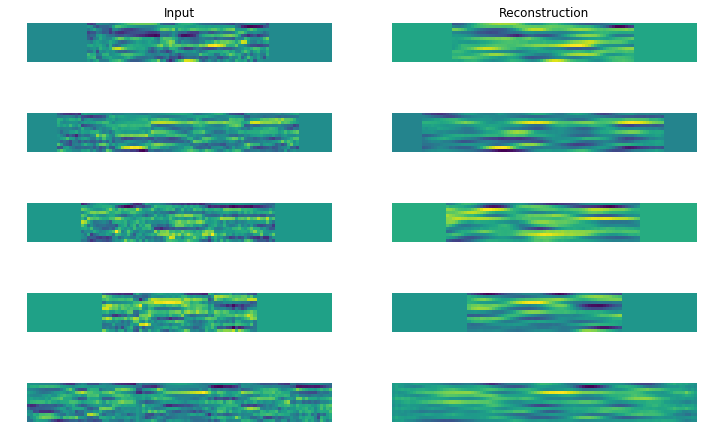

In [333]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i])
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i].T)
    plt.axis("off")

## CAE-CNN

In [338]:
cae_pretrain_model_fn = model_fn
intermediate_model_fn = path.join(output_dir, "cae_cnn.tmp.ckpt")
model_fn = path.join(output_dir, "cae_cnn.ckpt")

In [343]:
# Training parameters
learning_rate = 0.001
cae_n_epochs = 100
cae_n_val_interval = 1
cae_batch_size = 300

In [344]:
# Train CAE
train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, pair_list, cae_batch_size, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn

cae_record_dict = training.train_fixed_epochs_external_val(
    cae_n_epochs, optimizer, loss,
    train_batch_iterator, [a, a_mask, b, b_mask],
    samediff_val, save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=cae_n_val_interval,
    load_model_fn=cae_pretrain_model_fn
    )


2019-06-10 08:07:06.280960
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.ckpt
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
4.380 sec, train loss: 0.76120216, val loss: [0.2625402777014743, -0.20326107671132915] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
3.940 sec, train loss: 0.755153, val loss: [0.25245224574083636, -0.1958733821175006]
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
4.204 sec, train loss: 0.7511345, val loss: [0.2607124419204956, -0.19986157712210742]
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt


KeyboardInterrupt: 